In [36]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
from scipy.optimize import curve_fit
from collections import deque
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Dataframe defining functions

In [ ]:
def connectivityExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    connectivity_raw = data_structure['connectivity'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    connectivity_data = connectivity_raw.squeeze()
    # Create a DataFrame from the connectivity data
    connectivity_df = pd.DataFrame(connectivity_data, columns=['Parent', 'Daughter1', 'Daughter2', 'Daughter3'])
    connectivity_df['Parent'] = connectivity_df['Parent']
    connectivity_df['Daughter1'] = connectivity_df['Daughter1']
    connectivity_df['Daughter2'] = connectivity_df['Daughter2']
    connectivity_df['Daughter3'] = connectivity_df['Daughter3']
    # Save the DataFrame to inspect it
    return connectivity_df

def lengthExtractor(name):
    file_path = 'FluidsInput/FluidInput_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'lengths' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    length_raw = data_structure['lengths'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    length_data = length_raw.squeeze()
    # Create a DataFrame from the data
    length_df = pd.DataFrame(length_data, columns=['Length'])
    # Save the DataFrame to inspect it
    return length_df

def radiusExtractor(name):
    file_path = 'FluidsInput/FluidInput_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'radius' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    radius_raw = data_structure['rin'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    radius_data = radius_raw.squeeze()
    # Create a DataFrame from the data
    radius_df = pd.DataFrame(radius_data, columns=['Radius'])
    # Save the DataFrame to inspect it
    return radius_df

def lRR(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]): #iterate over every vessel
        length = data.iloc[i]['Length'] #pull the length value
        radius = data.iloc[i]['Radius'] #retreive radius value
        lrr_value = length/radius #calculate lrr
        lrr = np.append(lrr,lrr_value) #append lrr value to total list
    data['Length/Radius'] = lrr.tolist() #add list to table
    return data

def assignDepth(data):
    tree = {} 
    for _, row in data.iterrows(): #iterate over every row
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist() #only select daughter values that exist
        tree[parent] = daughters
    # Step 2: BFS traversal to assign depths
    depths = {}
    queue = deque([(data['Parent'].iloc[0], 0)])  # Start from root (first parent)

    while queue:
        node, depth = queue.popleft()
        depths[node] = depth
        for child in tree.get(node, []):
            if child not in depths:  # Avoid revisiting
                queue.append((child, depth + 1))
    data['Depth'] = data['Parent'].map(depths)
    return data

def radiusFinder(data):
    dv1r = np.empty((0,0))
    dv2r = np.empty((0,0))
    dv3r = np.empty((0,0))
    for i in np.arange(data.shape[0]):# iterate over every row
        dv1 = data.iloc[i]['Daughter1'] #pull radii values
        dv2 = data.iloc[i]['Daughter2']
        dv3 = data.iloc[i]['Daughter3']
        if math.isnan(dv1): #if daughter vessel 1 doesn't exist, none of them do
            dv1r = np.append(dv1r,np.nan)
            dv2r = np.append(dv2r,np.nan)
            dv3r = np.append(dv3r,np.nan)
            continue
        dv1r = np.append(dv1r,data.iloc[int(dv1)][2])
        dv2r = np.append(dv2r,data.iloc[int(dv2)][2])
        if math.isnan(dv3): #explicitly check whetehr dv3 exist
            dv3r = np.append(dv3r,np.nan)
            continue
        dv3r = np.append(dv3r,data.iloc[int(dv3)][2])
    data['DV1R'] = dv1r.tolist()
    data['DV2R'] = dv2r.tolist()
    data['DV3R'] = dv3r.tolist()
    #select and reorder columns
    data = data.loc[:,['Parent','Depth','Length','Radius','Length/Radius','Daughter1','DV1R','Daughter2','DV2R','Daughter3','DV3R']]
    return data

def alphaBeta(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #check if trifurcation, if it is then don't calculate
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R']
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #check if daughter vessels exist
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if dv1r>=dv2r: #case 1 of daughter vessels
            alpha_value = dv1r/pv
            beta_value = dv2r/pv
        else: #case 2 of daughter vessels
            alpha_value = dv2r/pv
            beta_value = dv1r/pv
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist() #add alpha and beta to total table
    data['Beta'] = beta.tolist()
    return data

def xiFinder(data):
    xi_values = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        rp = data.iloc[i]['Radius'] #pull all radii
        rd1 = data.iloc[i]['DV1R']
        rd2 = data.iloc[i]['DV2R']
        rd3 = data.iloc[i]['DV3R']
        if not math.isnan(rd3): #don't calculate if trifucation
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        if math.isnan(rd1): #don't calculate if no daughter vessels
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        while abs(error) > 1e-2: #allow for error up to 10^-2
            fun = rp**xi - rd1**xi - rd2**xi # solve at f(xi)
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2) #solve at f'(xi)
            xi = xi - fun/fun2 # new xi value
            error = rp**xi - rd1**xi - rd2**xi #calculate new error
        if xi > 6: #bound xi
            xi = 6
        if xi < 1:
            xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    data['Xi'] = xi_values.tolist()#add xi to the table
    #data['Error Newton'] = error_values.tolist()
    return data

def asymmetry(data):
    asym = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #don't calculate if trifucation
            asym = np.append(asym,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull radii
        dv2r = data.iloc[i]['DV2R']
        if math.isnan(dv1r): #if no daughters, skip
            asym = np.append(asym,np.nan)
            continue
        if dv1r>=dv2r: #case 1
            asym_value = (dv2r/dv1r)**2
        else: #case 2
            asym_value = (dv1r/dv2r)**2
        asym = np.append(asym,asym_value)
    data['Gamma'] = asym.tolist() #add to table
    return data

def area(data):
    area = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #if trifucation, skip
            area = np.append(area,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull necessary radii
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #if no daughters, skip
            area = np.append(area,np.nan)
            continue
        area_value = (dv1r**2+dv2r**2)/(pv**2) #calculate eta
        area = np.append(area,area_value)
    data['Eta'] = area.tolist() #add to table
    return data

def dataExtractor(name): #sequentially calls necessary functions to create full table
    connectivity = connectivityExtractor(name)
    length = lengthExtractor(name)
    radius = radiusExtractor(name)
    combined = pd.concat([connectivity.iloc[:, :1], length, radius, connectivity.iloc[:, 1:]], axis=1)
    lengthradius = lRR(combined)
    lengthradius.replace(0, np.nan, inplace=True) #ensure all nonexistent vessels have NaN
    lengthradius.at[0,'Parent']=0 #make sure first vessel is 0 (purposefully removed in last step for ease)
    depthness = assignDepth(lengthradius)
    allradii = radiusFinder(depthness)
    alphabetazed = alphaBeta(allradii)
    xi = xiFinder(alphabetazed)
    asymmetric = asymmetry(xi)
    areated = area(asymmetric)
    return areated

def saveStatistics(name): #saves the stats as .csv for exporting
    statistics = dataExtractor(name)[["Parent", "Depth",'Length','Radius','Length/Radius','Alpha','Beta','Xi','Gamma','Eta']] #selects correct columns
    file_path = 'Statistics/Statistics_' + name +'.csv'
    statistics.to_csv(file_path) #shouldn't return anything, just save

In [56]:
m3p4c = 'm3p4_060407'
control3p4 = dataExtractor(m3p4c)
m2p4c = 'm2p4_060407'
control2p4 = dataExtractor(m2p4c)
m1p4c = 'm1p4_060407'
control1p4 = dataExtractor(m1p4c)
m1p4h = 'm1p4_053007'
hyper1p4 = dataExtractor(m1p4h)
m2p4h = 'm2p4_053007'
hyper2p4 = dataExtractor(m2p4h)
m3p4h = 'm1p4_053107'
hyper3p4 = dataExtractor(m3p4h)


In [62]:
dropped = control3p4.dropna(subset='DV1R')
print(dropped.shape[0])
print(dropped['DV3R'].count())

431
26


# Bin Graphs

In [2]:
def bintoplotAB(data):
    filtered = data[data['Radius'] < .4*data.iloc[0][2]]
    filtered = filtered.drop('DV3R',axis=1)
    filtered = filtered.dropna()
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Radius'].mean()
    b = filtered.groupby('binned')['Alpha'].mean()
    c = filtered.groupby('binned')['Beta'].mean()
    return a,b,c


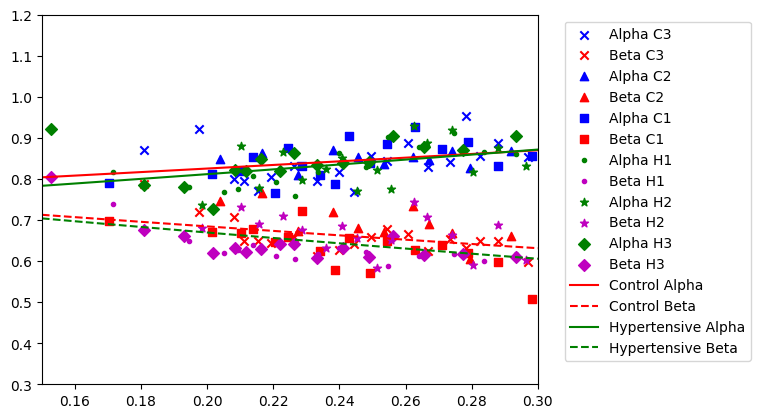

In [11]:
c3p4r,c3p4a,c3p4b = bintoplotAB(control3p4)
c2p4r,c2p4a,c2p4b = bintoplotAB(control2p4)
c1p4r,c1p4a,c1p4b = bintoplotAB(control1p4)
h1p4r,h1p4a,h1p4b = bintoplotAB(hyper1p4)
h2p4r,h2p4a,h2p4b = bintoplotAB(hyper2p4)
h3p4r,h3p4a,h3p4b = bintoplotAB(hyper3p4)

controla = np.concatenate((c1p4a,c2p4a,c3p4a),axis=0)
controlr = np.concatenate((c1p4r,c2p4r,c3p4r),axis=0)
controlb = np.concatenate((c1p4b,c2p4b,c3p4b),axis=0)
hypa = np.concatenate((h1p4a,h2p4a,h3p4a),axis=0)
hypb = np.concatenate((h1p4b,h2p4b,h3p4b),axis=0)
hypr = np.concatenate((h1p4r,h2p4r,h3p4r),axis=0)

def exponential(x, a, b):
    return a * np.exp(b * x)

paramsca, _ = curve_fit(exponential, controlr, controla)
paramscb, _ = curve_fit(exponential, controlr, controlb)
paramsha, _ = curve_fit(exponential, hypr, hypa)
paramshb, _ = curve_fit(exponential, hypr, hypb)

x_range = np.linspace(.15,.3, 100)

ca_fit = exponential(x_range, *paramsca)
cb_fit = exponential(x_range, *paramscb)
ha_fit = exponential(x_range, *paramsha)
hb_fit = exponential(x_range, *paramshb)

plt.scatter(c3p4r,c3p4a, c='b', marker='x', label='Alpha C3')
plt.scatter(c3p4r, c3p4b, c='r', marker='x', label='Beta C3')
plt.scatter(c2p4r,c2p4a, c='b', marker='^', label='Alpha C2')
plt.scatter(c2p4r, c2p4b, c='r', marker='^', label='Beta C2')
plt.scatter(c1p4r,c1p4a, c='b', marker='s', label='Alpha C1')
plt.scatter(c1p4r, c1p4b, c='r', marker='s', label='Beta C1')
plt.scatter(h1p4r,h1p4a, c='g', marker='.', label='Alpha H1')
plt.scatter(h1p4r, h1p4b, c='m', marker='.', label='Beta H1')
plt.scatter(h2p4r,h2p4a, c='g', marker='*', label='Alpha H2')
plt.scatter(h2p4r, h2p4b, c='m', marker='*', label='Beta H2')
plt.scatter(h3p4r,h3p4a, c='g', marker='D', label='Alpha H3')
plt.scatter(h3p4r, h3p4b, c='m', marker='D', label='Beta H3')
plt.plot(x_range, ca_fit, color='red', linestyle='-', label='Control Alpha')
plt.plot(x_range, cb_fit, color='red', linestyle='--', label='Control Beta')
plt.plot(x_range, ha_fit, color='green', linestyle='-', label='Hypertensive Alpha')
plt.plot(x_range, hb_fit, color='green', linestyle='--', label='Hypertensive Beta')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlim(.15, .3)
plt.ylim(.3, 1.2)
plt.show()

In [12]:
def boxtoplotLRR(data):
    filtered = data[data['Radius'] < .4*data.iloc[0][2]]
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Length/Radius'].mean()
    b = filtered.groupby('binned')['Radius'].mean()
    return a,b

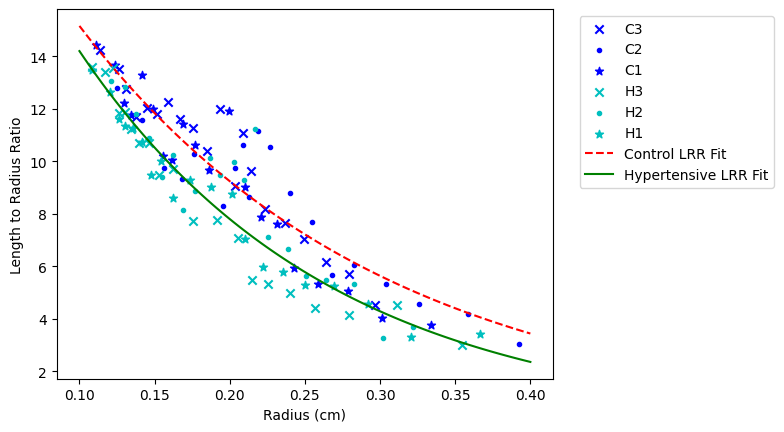

In [13]:
c3p4lrr,c3p4r = boxtoplotLRR(control3p4)
c2p4lrr,c2p4r = boxtoplotLRR(control2p4)
c1p4lrr,c1p4r = boxtoplotLRR(control1p4)
h3p4lrr,h3p4r = boxtoplotLRR(hyper3p4)
h2p4lrr,h2p4r = boxtoplotLRR(hyper2p4)
h1p4lrr,h1p4r = boxtoplotLRR(hyper1p4)

controllrr = np.concatenate((c1p4lrr,c2p4lrr,c3p4lrr),axis=0)
controlr = np.concatenate((c1p4r,c2p4r,c3p4r),axis=0)
hyplrr = np.concatenate((h1p4lrr,h2p4lrr,h3p4lrr),axis=0)
hypr = np.concatenate((h1p4r,h2p4r,h3p4r),axis=0)

def exponential(x, a, b):
    return a * np.exp(-b * x)

paramsclrr, _ = curve_fit(exponential, controlr, controllrr)
paramshlrr, _ = curve_fit(exponential, hypr, hyplrr)

x_range = np.linspace(.1,.4, 100)

clrr_fit = exponential(x_range, *paramsclrr)
hlrr_fit = exponential(x_range, *paramshlrr)

plt.scatter(c3p4r,c3p4lrr, c='b', marker='x', label='C3')
plt.scatter(c2p4r,c2p4lrr, c='b', marker='.', label='C2')
plt.scatter(c1p4r,c1p4lrr, c='b', marker='*', label='C1')
plt.scatter(h3p4r,h3p4lrr, c='c', marker='x', label='H3')
plt.scatter(h2p4r,h2p4lrr, c='c', marker='.', label='H2')
plt.scatter(h1p4r,h1p4lrr, c='c', marker='*', label='H1')
plt.plot(x_range, clrr_fit, color='red', linestyle='--', label='Control LRR Fit')
plt.plot(x_range, hlrr_fit, color='green', linestyle='-', label='Hypertensive LRR Fit')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel('Radius (cm)')
plt.ylabel('Length to Radius Ratio')
plt.show()

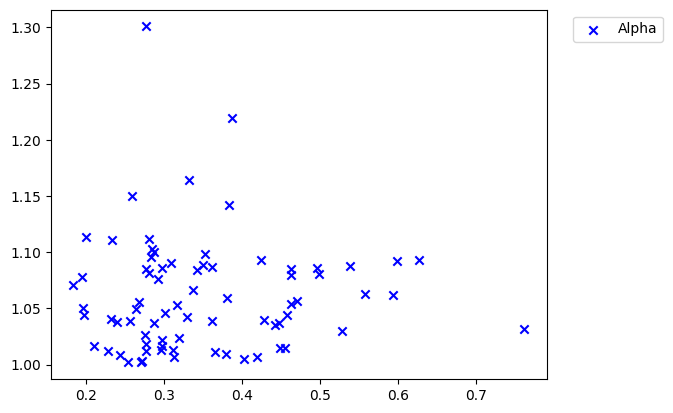

In [14]:
fc3p4 = control3p4[control3p4['Alpha'] > 1]
fc3p4a = fc3p4['Alpha']
fc3p4r = fc3p4['Radius']
plt.scatter(fc3p4r,fc3p4a, c='b', marker='x', label='Alpha')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

## Newton's Method

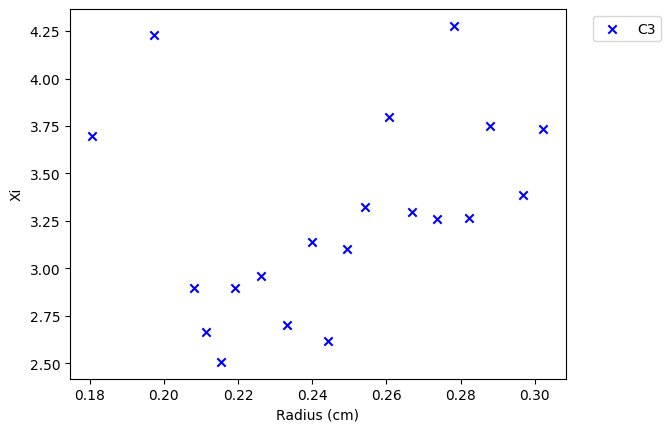

In [11]:
filtered = control3p4[control3p4['Radius'] < .4*control3p4.iloc[0][2]]
filtered = filtered[['Radius', 'Xi Newton']]
filtered = filtered.dropna()
labels = np.arange(20)
filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
a = filtered.groupby('binned')['Xi Newton'].mean()
b = filtered.groupby('binned')['Radius'].mean()
plt.scatter(b,a, c='b', marker='x', label='C3')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel('Radius (cm)')
plt.ylabel('Xi')
plt.show()